# Picking Algorithms (solution)

In this exercise, you get code snippets for an optimization that fails silently. You need to fix it by selecting a different optimization algorithm. To make it a bit easier, we provide the criterion value at the optimum.

If you find one that works, continue to search for one that works better. 

## Resources

- [List of algorithms](https://estimagic.readthedocs.io/en/stable/algorithms.html)
- [Documentation of algo_options](https://estimagic.readthedocs.io/en/stable/how_to_guides/optimization/how_to_specify_algorithm_and_algo_options.html)

In [1]:
import numpy as np
import estimagic as em

## Problem 1

This is a modified version of the `powell_singular` function from the More and Wild benchmark set. `powell_singular` is a differentiable nonlinear least squares problem. 

Our modification involves rounding the parameter vector to four digits before passing it to the original `powell_singular` function. This converts the function into a step function. 

In [2]:
def powell_steps(x):
    x = x.round(4)
    fvec = np.zeros(4)
    fvec[0] = x[0] + 10 * x[1]
    fvec[1] = np.sqrt(5.0) * (x[2] - x[3])
    fvec[2] = (x[1] - 2 * x[2]) ** 2
    fvec[3] = np.sqrt(10.0) * (x[0] - x[3]) ** 2
    out = {"root_contributions": fvec, "value": np.dot(fvec, fvec)}
    return out


powell_start = np.array([3.0, -1, 0, 1])

In [3]:
# optimal criterion value
powell_criterion = 0

In [4]:
res_powell = em.minimize(
    criterion=powell_steps,
    params=powell_start,
    algorithm="scipy_lbfgsb",
)

res_powell

Minimize with 4 free parameters terminated successfully after 1 criterion evaluations, 1 derivative evaluations and 0 iterations.

The value of criterion improved from 215.00000000000003 to 215.00000000000003.

The scipy_lbfgsb algorithm reported: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL

---
The optimization thinks it terminated "successfully" but when you look at `res.params` you see that it actually got stuck at the start values.

In [5]:
res_powell.params

array([ 3., -1.,  0.,  1.])

## Task 1:

- Try to understand why the algorithm `scipy_lbfgsb` got stuck at the start parameters.
- Find an algorithm that converges to the optimum.

## Solution 1:


### Slice Plot

- [How to guide in the documenation](https://estimagic.readthedocs.io/en/stable/how_to_guides/optimization/how_to_visualize_an_optimization_problem.html#creating-a-simple-slice-plot)
- Aims to visualize (higher-dimensional) functions in a neighborhood
- Can learn about differentiability and randomness 

#### Zoomed out

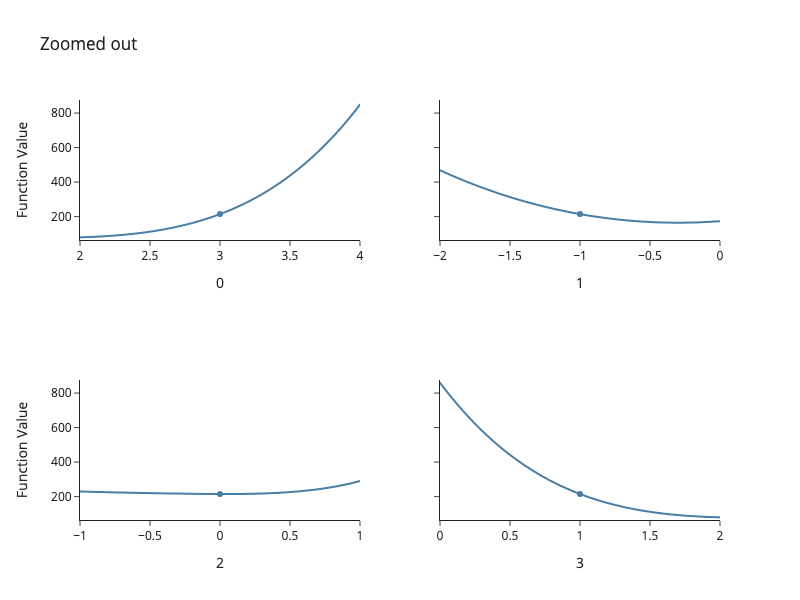

In [6]:
fig = em.slice_plot(
    func=powell_steps,
    params=powell_start,
    lower_bounds=powell_start - 1,
    upper_bounds=powell_start + 1,
    n_gridpoints=1_000,
    title="Zoomed out",
)
fig.show(renderer="png")

#### Zoomed in

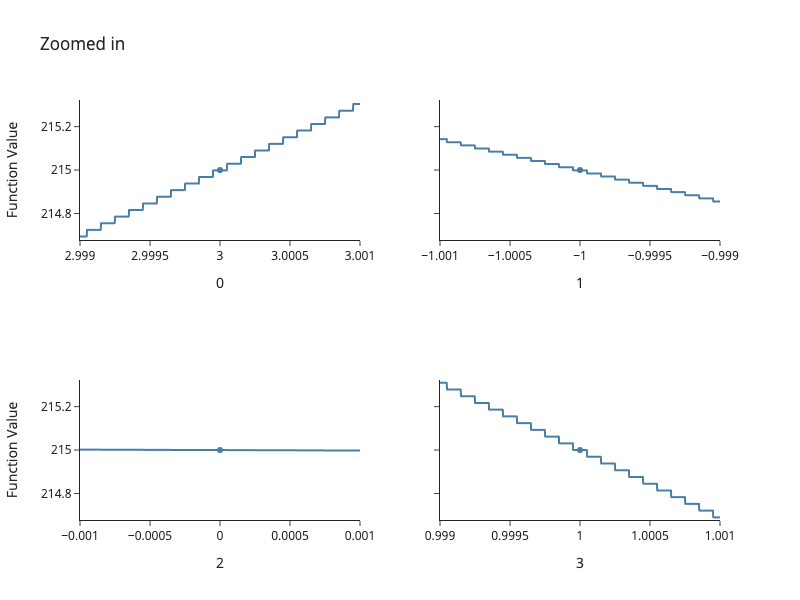

In [7]:
fig = em.slice_plot(
    func=powell_steps,
    params=powell_start,
    lower_bounds=powell_start - 1e-3,
    upper_bounds=powell_start + 1e-3,
    n_gridpoints=1_000,
    title="Zoomed in",
)
fig.show(renderer="png")

- The `"lbfgsb"` algorithm uses gradient information to calculate a search direction and as a termination criterion
- Because `powell_steps` rounds the input, the gradient is zero almost everywhere. Hence, it thinks it is at an optimum.
- Gradient-free optimizers are a better choice for this function
- For maximum efficiency, use a gradient-free optimizer that exploits the least-squares structure of the problem, e.g.,`nag_dfols`

In [8]:
res_powell = em.minimize(
    criterion=powell_steps,
    params=powell_start,
    algorithm="nag_dfols",
)

In [9]:
res_powell.params

array([ 0.00795156, -0.00078252,  0.00372655,  0.00367902])

In [10]:
res_powell.criterion

7.940018600000003e-09

## Important warning

- This example gave the impression that it would be a reasonable strategy to always use gradient-free optimizers because they are more robust
- This would be a bad idea!
- It is easy to find examples where gradient-free optimizers break down, and gradient-based ones solve the problem quickly and robustly